# Lecture #15: Black-box Variational Inference
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
import numpy
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm
from autograd import grad
from autograd.misc.optimizers import adam
import numpy
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
from IPython.display import YouTubeVideo
%matplotlib inline

In [2]:
def generate_data(N, y_var=1.):
    '''generate training data with a gap, testing data uniformly sampled'''
    #training x
    x_train = np.hstack((np.linspace(-10, -5, N), np.linspace(5, 10, N)))
    #function relating x and y
#     f = lambda x:  0.01 * x**3
    f = lambda x: 2 * x
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, y_var**0.5, 2 * N)

    ## generate testing data
    #nubmer of testing points
    N_test = 100
    #testing x
    x_test = np.linspace(-10, 10, N_test)
    y_test = f(x_test) + np.random.normal(0, y_var**0.5, N_test)

    return x_train, y_train, x_test, y_test

def bayesian_polynomial_regression(x, y, x_test, y_test, prior_var, y_var, ax, S=100, poly_degree=10):
    '''visualize the posterior predictive of a Bayesian polynomial regression model'''
    poly = PolynomialFeatures(poly_degree)
    #transform training x: add polynomial features
    x_poly = poly.fit_transform(x.reshape((-1, 1)))
    #transform x_test: add polynomial features
    x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))
    #Gaussian log pdf
    gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

    #reshape y into 2D array
    y_matrix = y.reshape((-1, 1))

    #define the covariance and precision matrices of the prior on the weights
    prior_variance = np.diag(prior_var * np.ones((x_poly.shape[1], )))
    prior_precision = np.linalg.inv(prior_variance)

    #defining the posterior variance
    joint_variance = np.linalg.inv(prior_precision + 1. / y_var * x_poly.T.dot(x_poly))
    #defining the posterior mean
    joint_mean = joint_variance.dot(x_poly.T.dot(y_matrix)) * 1. / y_var

    #sampling S points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=S)
    #sampling S points from the posterior predictive
    y_predict_noiseless = np.array([x_test_poly.dot(sample) for sample in posterior_samples])
    y_predict_bayes = y_predict_noiseless + np.random.normal(0, y_var**0.5, size=(S, len(x_test)))
    
    #compute log likelihood for the test data
    log_likelihood_bayes = []
    for n in range(len(y_test)):
        log_likelihood_bayes.append(gaussian_log_pdf(y_predict_noiseless[:, n], y_var, y_test[n]).mean())
    log_likelihood_bayes = np.array(log_likelihood_bayes)
    
    #compute the 95 percentiles of the posterior predictives
    ub_bayes = np.percentile(y_predict_bayes, 97.5, axis=0)
    lb_bayes = np.percentile(y_predict_bayes, 2.5, axis=0)
    
    #visualize the posterior predictive distribution
    ax.scatter(x, y, color='red', s=10, alpha=0.5, label='train data')
    ax.fill_between(x_test, ub_bayes, lb_bayes, color='blue', alpha=0.2, label="test log-likelihood: {}".format(np.round(np.sum(log_likelihood_bayes), 4)))
    ax.set_title('posterior predictive distribution of bayesian regression model with prior variance of {}'.format(prior_var))
    ax.legend(loc='best')
    ax.set_xlim([-10, 10])
    
    return ax, joint_variance, joint_mean

def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [3]:
def variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    #define the log prior on the model parameters
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    def log_lklhd(W):
        S = W.shape[0]
        constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * N
        exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - forward(W, x_train))**2, axis=2).flatten()
        return constant + exponential

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.ones(D)
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

def variational_polynomial_regression(Sigma_W, sigma_y, x_test, y_test, x_train, y_train, forward, ax, posterior_sample_size=100, S=2000, max_iteration=2000, step_size=1e-2, verbose=True):
    '''perform bayesian regression: infer posterior, visualize posterior predictive, compute log-likelihood'''
    D = Sigma_W.shape[0]
    
    #approximate posterior with mean-field gaussian
    variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train, forward, S, max_iteration, step_size, verbose)
    
    #sample from the variational posterior
    var_means = variational_params[:D]
    var_variance = np.diag(np.exp(variational_params[D:])**2)
    posterior_samples = np.random.multivariate_normal(var_means, var_variance, size=posterior_sample_size)

    #predict on x_test
    y_predict_noiseless = forward(posterior_samples, x_test)
    y_pred = y_predict_noiseless + np.random.normal(0, sigma_y**0.5, size=(posterior_sample_size, len(x_test)))

    #Gaussian log pdf
    gaussian_log_pdf = lambda mu, sigma_sq, x: -0.5 * (np.log(2 * np.pi * sigma_sq) + (x - mu)**2 / sigma_sq)

    #compute log likelihood for the test data
    log_likelihood = []
    for n in range(len(y_test)):
        log_likelihood.append(gaussian_log_pdf(y_predict_noiseless[:, n], sigma_y, y_test[n]).mean())
    log_likelihood = np.array(log_likelihood).sum()

    #compute the 95 percentiles of the posterior predictives
    ub_bayes = np.percentile(y_pred, 97.5, axis=0)
    lb_bayes = np.percentile(y_pred, 2.5, axis=0)
    
    #visualize the posterior predictive distribution
    ax.scatter(x_train, y_train, color='red', s=10, alpha=0.5, label='train data')
    ax.fill_between(x_test, ub_bayes, lb_bayes, color='green', alpha=0.2, label='test log-likelihood:{}'.format(np.round(log_likelihood, 4)))
    ax.set_title('mean-field Gaussian variational approximation of the posterior')
    ax.legend(loc='best')
    
    return ax, var_variance, var_means

## Administrative Matters

1. **Attendance Quiz:** https://tinyurl.com/y3qkvk5c<br><br>

2. **Homework #7:** The suggested settings for running HMC on your BNN is so that you get a reasonable looking plot and a sense of how long HMC can take - your sampler will not have converged in 10,00 iterations!<br><br>

3. **Homework #8:** The homework this week is not as intense as Homework #7. If you've made a good effort on Homework #7, then there isn't anything extra you need to implement - you just need to put pieces of code together.<br><br>

4. **Project Check-point #2:** Reminder to contact your TF and instructor for a meeting if you haven't done so already.

## Outline
1. Review of Neural Network Models
2. Bayesian Neural Networks
3. Black-box Variational Inference

# Review of Neural Network Models

## How Would You Parameterize a Non-linear Trend?
In non-linear regression, we are interested in modeling observed outcome $Y^{(n)}$ as a non-linear function of observed covariates $\mathbf{X}^{(n)}$:
\begin{align}
\mu &= g_{\mathbf{w}}(\mathbf{X}^{(n)})\\
Y^{(n)}&\sim \mathcal{N}(\mu, \sigma^2)
\end{align}
But it's not easy to think of a function class $g(x)$ can capture the trend in the data (e.g. polynomial or sinusoical)?
<img src="./fig/fig12.png" style='height:400px;'>


## Representing Arbitrarily Complex Functions

**Motto:** neural netoworks build up a complex function $g$ by **composing** simple nonlinear functions. We represent neural networks as **layered directed graphs** where each node $i$ in the $l$-th layer represents the function $f\left(\sum_{j}w^{l-1}_{ji} h^{l-1}_j\right)$, $h^{l-1}_j$ being the hidden nodes from the $l-1$-th layer.

<img src="./fig/fig5.png" style='height:300px;'>

This is a ***neural network***. We denote the weights of the neural network collectively by $\mathbf{W}$.
The non-linear function $f$ is called the ***activation function***.

## Design Choices: Depth or Width
Ideally, we want our architecture to be able to express a number of very complex functions, since we don't know what is appropriate for our data. So what architecture is more effective for expressing complex functions?

<table>
    <tr>
        <td>
            <img src="./fig/wide.jpg" style="height: 350px;" align="center"/>
        </td>
        <td>
            <img src="./fig/deep.jpg" style="height: 350px;" align="center"/>
        </td>
    </tr>
</table>


## Neural Networks Regression

**Model for Regression:** $Y^{(n)}\sim \mathcal{N}(\mu, \sigma^2)$, $\mu = g_\mathbf{W}(\mathbf{X}^{(n)})$, where $g_\mathbf{W}$ is a neural network with parameters $\mathbf{W}$.

**Training Objective:** find $\mathbf{W}$ to maximize the likelihood of our data. This is equivalent to minimizing the Mean Square Error,
$$
\max_{\mathbf{W}}\, \mathrm{MSE}(\mathbf{W}) = \frac{1}{N}\sum^N_{n=1} \left(y_n - g_\mathbf{W}(x_n)\right)^2
$$

**Optimizing the Training Objective:** The main challenge of optimizing the objective is computing the gradient of a neural network. Luckily, the gradient can be computed in an algorithmic way using the chain rule, working from the output node **backwards** towards the input. For example, the derivative with respect to the hidden node $h^l_i$ is:
$$
\frac{\partial \mathrm{MSE}}{\partial h^l_i} = \sum_{j}\underbrace{\frac{\partial \mathrm{MSE}}{\partial h^{l+1}_j}}_{\text{derivative from layer $l\quad$}} \underbrace{\frac{\partial h^{l+1}_j}{\partial h^{l}_i}}_{\text{derivative of $f\left(\sum_{k}w_k h_k\right)$}}
$$
Using this backwards gradient computation, we can optimize a neural network with respect to the MSE using **gradient descent**.

## The Maximum Likelihood Objective is Non-Convex for Neural Networks
Unfortunately, the likelihood and MSE functions for neural network regression models are not convex! This means that **just because your gradient is zero, it doens't mean you've optimized anything**.

<img src="./fig/loss_landscape.jpg" style="height: 350px;" align="center"/>

## Neural Network Regression vs Linear Regression

Linear models are easy to interpret. Once we've found the MLE of the model parameters, we can formulate scientific hypotheses about the relationship between the outcome $Y$ and the covariates $\mathbf{X}$:

\begin{align}
    \widehat{\text{income}} = 2 * \text{education (yr)} + 3.1 * \text{married} - 1.5 * \text{gaps in work history}
\end{align}

What do the weights of a neural network tell you about the relationship between the covariates and the outcome?
<img src="./fig/fig5.png" style='height:250px;'>

## Generalization Error and Bias/Variance
Complex models have ***low bias*** -- they can model a wide range of functions, given enough samples.

But complex models like neural networks can use their 'extra' capacity to explain non-meaningful features of the training data that are unlikely to appear in the test data (i.e. noise). These models have ***high variance*** -- they are very sensitive to small changes in the data distribution, leading to drastic performance decrease from train to test settings.

<table>
    <tr>
        <td>
            <img src="./fig/fig11.png" style="width: 380px;" align="center"/>
        </td>
        <td>
            <img src="./fig/fig12.png" style="width: 380px;" align="center"/>
        </td>
    </tr>
</table>

# Bayesian Neural Networks

## Bayesian Polynomial Regression is Bayesian Linear Regression
A Bayesian polynomial regression model uses a polynomial of degree $D$ to capture the relationship between $X\in \mathbb{R}$ and $Y$:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, \sigma^2_W \mathbf{I})\\
\mu^{(n)}&= w_0 + w_1 X^{(n)} + w_2 (X^{(n)})^2 + \ldots + w_D(X^{(n)})^D\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, \sigma^2_Y)
\end{align}

Rather than considering the polynomial as a non-linear function of $X$, we can see it as a linear function of the vector $\mathbf{X} = [1, X, X^2, \ldots, X^D] \in \mathbb{R}^{D+1}$:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, \sigma^2_W \mathbf{I})\\
\mu^{(n)}&= \mathbf{W}^\top \mathbf{X}^{(n)}\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, \sigma^2_Y)
\end{align}

This means that for a Bayesian polynomial regression model, the posterior $p(\mathbf{X} | \text{Data})$ is a multivariate Gaussian (just as in the case of Bayesian linear regression, see HW#0).

## Bayesian Neural Networks
A **Bayesian neural network (BNN)** is a Bayesian model for regression that uses a neural network to capture the relationship between $\mathbf{X}$ and $Y$:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, \sigma^2_W \mathbf{I})\\
\mu^{(n)}&= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, \sigma^2_Y)
\end{align}

Unfortunately, the posterior of a neural network is multimodal and very complex, posing a challenge for samplers. Furthermore, training data for BNNs are typically large, this makes gradient-based samplers like HMC extremely inefficient -- in every leap-frog iteration of HMC, the gradient $\frac{\partial U(q)}{\partial q}$ requires an evaluation over the entire training data set. 

**See course project papers:** 
1. NeuTra-lizing Bad Geometry in Hamiltonian Monte Carlo Using Neural Transport
2. Stochastic Gradient Hamiltonian Monte Carlo

# Black-box Variational Inference

## Review of Variational Inference

**Goal:** given a target posterior distribution $p(\psi | Y_1, \ldots, Y_N)$, $\psi \in \mathbb{R}^I$ we want to find a distribution $q(\psi |\lambda^*)$ in a family of distributions $Q = \{q(\psi |\lambda) | \lambda \in \Lambda \}$ such that $q(\psi |\lambda^*)$ best approximates $p$. 

**Design Choices:** we need to choose:

A. ***(Variational family)*** a family $Q$ of candidate distributions for approximating $p$. The members of $Q$ are called the ***variational distributions***.

  **Our Choice:**  we assume that the joint $q(\psi)$ factorizes completely over each dimension of $\psi$, i.e. $q(\psi)= \prod_{i=1}^I q(\psi_i | \lambda_i)$. This is called the ***mean field assumption***. What can go wrong with this design choice?
  
B. ***(Divergence measure)*** a divergence measure to quantify the difference between $p$ and $q$.

  **Our Choice:** 
  $$D_{\text{KL}}(q(\psi | \lambda) \| p(\psi | Y_1, \ldots, Y_N)) = \mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left( \frac{q(\psi | \lambda)}{p(\psi | Y_1, \ldots, Y_N)} \right) \right]$$
  What can go wrong with this design choice?
  

## Variational Inference as Optimization

We can now formalize the the problem of variational inference for a target distribution $p(\psi)$: 

Find a $q(\psi|\lambda^*)$ such that 

\begin{aligned}
\lambda^* = \underset{\lambda}{\text{argmin}}\; D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) = \underset{\lambda}{\text{argmin}}\; \mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{q(\psi | \lambda)}{p(\psi|Y_1, \ldots, Y_N))}\right) \right]
\end{aligned}

Recall that for EM, we had proved that minimizing the KL is equivalent to maximizing the ELBO (for which it is easier to compute the gradient). We will do the same here:

\begin{aligned}
\underset{\lambda}{\min}D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) &\overset{\text{equiv}}{\equiv} \underset{\lambda}{\max} -D_{\text{KL}}(q(\psi|\lambda) \| p(\psi|Y_1, \ldots, Y_N))) \\
&= \underset{\lambda}{\max} -\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{q(\psi | \lambda)}{p(\psi|Y_1, \ldots, Y_N))} \right)\right] \\
&= \underset{\lambda}{\max}\underbrace{\mathbb{E}_{\psi \sim q(\psi|\lambda)}\left[\log\left(\frac{p(\psi, Y_1, \ldots, Y_N))}{q(\psi | \lambda)} \right)\right]}_{ELBO(\lambda)} - \log p(Y_1, \ldots, Y_N).
\end{aligned}

Thus, the variational objective can be rephrased as maximizing the $ELBO$.

## Variational Inference for Bayesian Neural Networks

Consider a Bayesian neural network:
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, \sigma^2_W \mathbf{I})\\
Y^{(n)} &\sim \mathcal{N}(g_{\mathbf{W}}(\mathbf{X}^{(n)}), \sigma^2_Y)
\end{align}
and a mean-field Gaussian variational family:
$$
q(\mathbf{W} | \mu, \Sigma) = \mathcal{N}(\mathbf{W}; \mu, \Sigma)
$$
where $\Sigma$ is a diagonal matrix.

The ELBO is: 
\begin{align}
ELBO(\mathbf{W}) &= \mathbb{E}_{\mathbf{W} \sim q(\mathbf{W} | \mu, \Sigma)} \left[ \log \left( \frac{p(\mathbf{W}) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W})}{q(\mathbf{W} | \mu, \Sigma)} \right) \right]\\
&= \mathbb{E}_{\mathbf{W} \sim q(\mathbf{W} | \mu, \Sigma)} \left[ \log \left( \frac{\mathcal{N}(\mathbf{W}; 0, \sigma^2_W \mathbf{I}) \prod_{n=1}^N \mathcal{N}(Y^{(n)}; g_{\mathbf{W}}(\mathbf{X}^{(n)}), \sigma^2_Y)}{\mathcal{N}(\mathbf{W}; \mu, \Sigma)} \right) \right].
\end{align}

To find the optimal variational parameters such that $\mu^*, \Sigma^* = \mathrm{argmax}\, ELBO(\mathbf{W})$, we need to compute the gradient of the ELBO:

\begin{aligned}
\nabla_{\mu, \Sigma}\,\underbrace{\mathbb{E}_{\mathbf{W} \sim q(\mathbf{W} | \mu, \Sigma)} \left[ \log \left( \frac{p(\mathbf{W}) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W})}{q(\mathbf{W} | \mu, \Sigma)} \right) \right]}_{ELBO(\mathbf{W})}.
\end{aligned}

## Black-Box Variational Inference

The ***Black-box Variational Inference (BBVI)*** algorithm for BNN's:
0. **Initialization:** pick an intial value $\mu^{(0)}, \Sigma^{(0)}$
1. **Gradient Ascent:** repeat:

   1. Approximate the gradient 
   \begin{align}
   \nabla_{\mu, \Sigma} \, ELBO(\mathbf{W}) &= \mathbb{E}_{\mathbf{W} \sim q(\mathbf{W} | \mu, \Sigma)}\left[ \nabla_{\mu, \Sigma}\, q(\mathbf{W} | \mu, \Sigma) * \log \left( \frac{p(\mathbf{W}) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W})}{q(\mathbf{W} | \mu, \Sigma)} \right) \right]\\
   &\approx\frac{1}{S}\underbrace{\sum_{s=1}^S \nabla_{\mu, \Sigma}\, \log q(\mathbf{W}^s | \mu, \Sigma) * \log \left( \frac{p(\mathbf{W}^s) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W}^s)}{q(\mathbf{W}^s | \mu, \Sigma)} \right)}_{{\text{score function gradient}}},
   \end{align}
   where $\mathbf{W}^s\sim q(\mathbf{W} | \mu^{\text{current}}, \Sigma^{\text{current}})$.
   2. Update parameters $(\mu^{\text{current}}, \Sigma^{\text{current}}) \leftarrow (\mu^{\text{current}}, \Sigma^{\text{current}}) + \eta * {\text{score function gradient}}$
   
See Lecture #15 board-work or the appendix of "Black-box Variational Inference" for the derivation of the expression for the gradient of the ELBO.

## Variance of the Gradient Estimate

In Black-Box Variational Inference, we estimate the gradient using Monte Carlo estimation (i.e. the score function gradient approximation):

$$
\nabla_{\mu, \Sigma} \, ELBO(\mathbf{W}) \approx \frac{1}{S} {\sum_{s=1}^S \nabla_{\mu, \Sigma}\,\log q(\mathbf{W}^s | \mu, \Sigma) * \log \left( \frac{p(\mathbf{W}^s) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \mathbf{W}^s)}{q(\mathbf{W}^s | \mu, \Sigma)} \right)},
$$

where $\mathbf{W}^s\sim q(\mathbf{W} | \mu^{\text{current}}, \Sigma^{\text{current}})$.

As in the case with every MC estimate, we worry about variance. As it turns out, the score function gradient approximation has very high variance. This leads to slow convergence for gradient descent. To mitigate this, we need to employ a number of **variance reduction methods**.

In the original paper "Black-Box Variational Inference", the authors implement control variates and Rao-Blackwellization. 

## Gradient of the ELBO with the Reparametrization Trick

An alternative to using the log-derivative trick to computing the gradient of the ELBO is to use the reparametrization trick. 

We note that since $q(\mathbf{W} | \mu, \Sigma) = \mathcal{N}(\mathbf{W};\mu, \Sigma )$, sampling $W\sim q(\mathbf{W} | \mu, \Sigma)$ is equivalent to sampling $\epsilon \sim \mathcal{N}(0, \mathbf{I})$ and then transforming the sample $\mathbf{W} = \epsilon^\top \Sigma^{1/2} + \mu$, where $\mathbf{I}$ and $\Sigma$ have the same dimensions.

Thus, we can rewrite the ELBO:
<img src="./fig/reparametrized_grad.png" style='height:300px;'>

## Black-Box Variational Inference with the Reparametrization Trick

The ***Black-box Variational Inference (BBVI) with the reparametrization trick*** or ***Bayes By Backprop*** algorithm for BNN's:
0. **Initialization:** pick an intial value $\mu^{(0)}, \Sigma^{(0)}$
1. **Gradient Ascent:** repeat:

   1. Approximate the gradient 
   \begin{align}
   \nabla_{\mu, \Sigma} \, ELBO(\mathbf{W}) \approx& \frac{1}{S} \sum_{s=1}^S \nabla_{\mu, \Sigma} \log \left[p(\epsilon_s^\top \Sigma + \mu) \prod_{n=1}^N p(Y^{(n)} | \mathbf{X}^{(n)}, \epsilon_s^\top \Sigma + \mu)\right] \\
   &- \nabla_{\mu, \Sigma}\underbrace{\mathbb{E}_{\mathbf{W} \sim \mathcal{N}(\mu, \Sigma )}\left[\log \mathcal{N}(\mathbf{W};\mu, \Sigma ) \right]}_{\text{Guassian entropy: has closed form}},
   \end{align}
   where $\epsilon_s \sim \mathcal{N}(0, \mathbf{I})$.
   2. Update parameters $(\mu^{\text{current}}, \Sigma^{\text{current}}) \leftarrow (\mu^{\text{current}}, \Sigma^{\text{current}}) + \eta * {\text{score function gradient}}$
   
See Lecture #15 board-work or the appendix of "Black-box Variational Inference" for the derivation of the expression for the gradient of the ELBO.

In [6]:
##set random seed
rand_state = 0
random = np.random.RandomState(rand_state)

##generate training data
#number of points in each of the two segments of the domain
N = 20
#output variance
y_var = 1.
x_train, y_train, x_test, y_test = generate_data(N, y_var)
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)

##transform covariates for polynomial regression
poly = PolynomialFeatures(1)
#transform x: add polynomial features
x_poly = poly.fit_transform(x_train.reshape((-1, 1)))
#transform x_test: add polynomial features
x_test_poly = poly.fit_transform(x_test.reshape((-1, 1)))

##define dimensions
N = x_poly.shape[0]
D = x_poly.shape[1]

##define variances
sigma_y = 1.**2
weight_noise = 5**2
Sigma_W = weight_noise * np.eye(D)

##polynomial function
def forward(w, x):
    x_poly = poly.fit_transform(x.reshape((-1, 1))) 
    return np.dot(w, x_poly.T)

x_train shape (40,)
y_train shape (40,)


## BBVI for Bayesian Linear Regression (Posterior Predictives)

Optimizing variational parameters...


KeyboardInterrupt: 

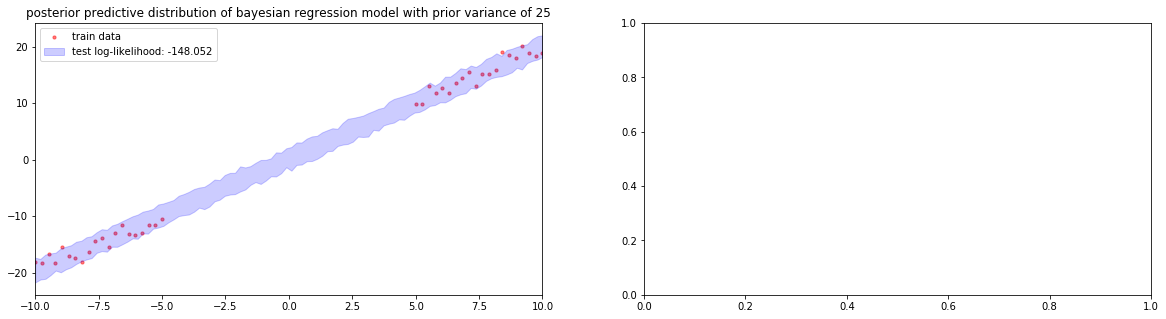

In [5]:
posterior_sample_size = 100
##visualize the posterior predictive of a bayesian polynomial regression model
#prior variance
prior_var = 5**2
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0], joint_variance, joint_mean = bayesian_polynomial_regression(x_train, y_train, x_test, y_test, prior_var, y_var, ax[0], S=posterior_sample_size, poly_degree=1)
ax[1], var_variance, var_mean = variational_polynomial_regression(Sigma_W, sigma_y, x_test, y_test, x_train, y_train, forward, ax[1], posterior_sample_size=posterior_sample_size, S=4000, max_iteration=2000, step_size=1e-1, verbose=False)
plt.show()

## BBVI for Bayesian Linear Regression (Posteriors)

In [ ]:
#define points that include most of the probability mass of the pdf
x, y = numpy.mgrid[-0.33:0.4:.005, 1.925:2.025:.005]
pos = numpy.dstack((x, y))
#get the value of the target pdf at those points
z_p = sp.stats.multivariate_normal(joint_mean.flatten(), joint_variance).pdf(pos)
#get the value of the variational pdf at those points
z_q = sp.stats.multivariate_normal(var_mean, var_variance).pdf(pos)

In [ ]:
#plot the target density against variational densities
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.contourf(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z_p, levels=14, cmap='Reds', alpha=0.8)
ax.contour(x, y, z_q, levels=14, cmap='Blues', alpha=1.)
ax.set_title('Approximate posterior (blue) vs actual posterior (red)')
plt.show()